In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.visualization import AsinhStretch
from gzbuilder_analysis import load_aggregation_results
from gzbuilder_analysis.aggregation.spirals.oo import Arm
from gzbuilder_analysis.data import download_sdss_rgb_cutout

In [3]:
agg_res = load_aggregation_results('../gzbuilder_results/output_files/aggregation_results')

In [4]:
fm = pd.read_pickle('lib/fitting_metadata.pkl')

In [5]:
arms = agg_res.apply(lambda a: a.spiral_arms).apply(pd.Series).add_prefix('arm-')

In [6]:
two_or_more_arms = arms[arms['arm-1'].notna()]

In [7]:
isinstance(two_or_more_arms.iloc[0][0], Arm)

True

In [8]:
selection = two_or_more_arms[two_or_more_arms.applymap(lambda a: a.pa if isinstance(a, Arm) else np.nan).apply(lambda a: a.max() - a.min() > 20, axis=1)]

In [9]:
fm.loc[selection.index[3]]

psf                    [[0.00016263543511740863, 0.000325177737977355...
pixel_mask             [[True, True, True, True, True, True, True, Tr...
galaxy_data            [[0.01405712422185256, 0.017494168673034754, 0...
montage_wcs            WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...
original_wcs           WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...
multiplier                                                       1.58047
sigma_image            [[0.017574397130383772, 0.01764494300383544, 0...
width                                                                 74
size_diff                                                       0.144531
rotation_correction                                                    0
Name: 20902080, dtype: object

In [10]:
s = AsinhStretch()

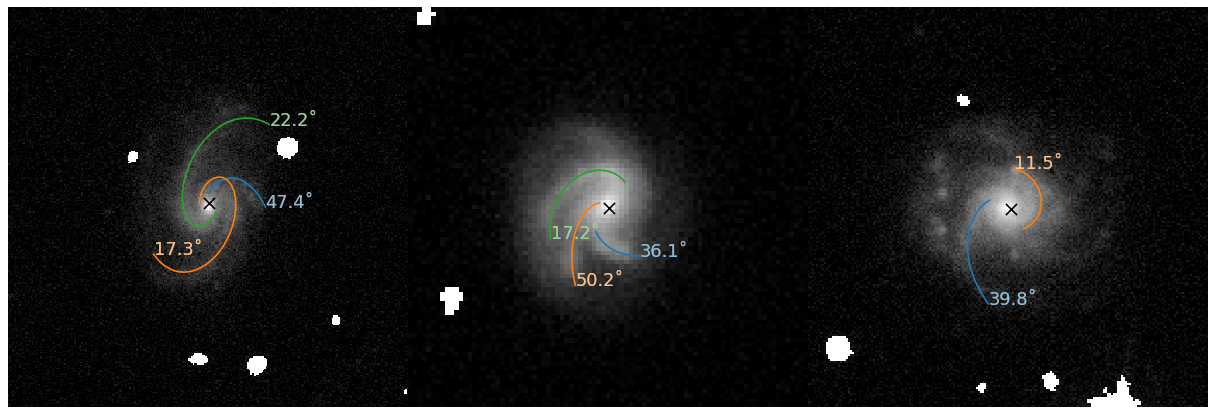

In [11]:
f, axs = plt.subplots(ncols=3, dpi=80, figsize=(5 * 3, 5))
idxs = [2, 5, 6]
for ax, i in zip(axs, idxs):
    plt.sca(ax)
    plt.imshow(s(fm.loc[selection.index[i]]['galaxy_data']), cmap='gray')
    for j, arm in enumerate(selection.iloc[i].dropna()):
        p = 0 if (
            np.add.reduce((arm.reprojected_log_spiral[0] - arm.centre_pos)**2)
            > np.add.reduce((arm.reprojected_log_spiral[-1] - arm.centre_pos)**2)
        ) else -1
        plt.plot(*arm.reprojected_log_spiral.T, c=f'C{j}')
        plt.text(*arm.reprojected_log_spiral[p], f'{arm.pa:.1f}˚', c=f'w', fontsize=16)
        plt.text(*arm.reprojected_log_spiral[p], f'{arm.pa:.1f}˚', c=f'C{j}', alpha=0.5, fontsize=16)
    plt.scatter(*arm.centre_pos, c='k', marker='x', s=100)
    plt.axis('off')
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
# plt.tight_layout()
plt.savefig('plots/example-spiral-angles.pdf', bbox_inches='tight')

In [13]:
catalog = pd.read_csv('../source_files/galaxy-builder-catalogue.csv').set_index('galaxy_builder_id')

In [14]:
image_locs = pd.read_csv('lib/galaxy-builder-subjects.csv', index_col=0) \
    .metadata \
    .apply(json.loads).apply(pd.Series) \
    [['ra', 'dec']] \
    .drop_duplicates() \
    .reindex(np.unique(catalog.query('bar_fraction > 0.05').index)) \
    .dropna()
print(len(image_locs))

28


In [15]:
image_locs = catalog.query('bar_fraction > 0.05').sort_values('chisq')[['ra', 'dec']].head(16)

In [23]:
len(pd.read_csv('lib/galaxy-builder-classifications.csv', index_col=0))

18411

In [20]:
from tqdm import tqdm
ims = pd.Series([], dtype=object)
with tqdm(image_locs.iterrows(), total=len(image_locs)) as bar:
    for i, (idx, row) in enumerate(bar):
        data = fm['galaxy_data'].loc[idx]
        ims.loc[idx] = download_sdss_rgb_cutout(*row[['ra', 'dec']], fm['galaxy_data'].loc[idx].shape)

100%|██████████| 16/16 [00:06<00:00,  2.52it/s]


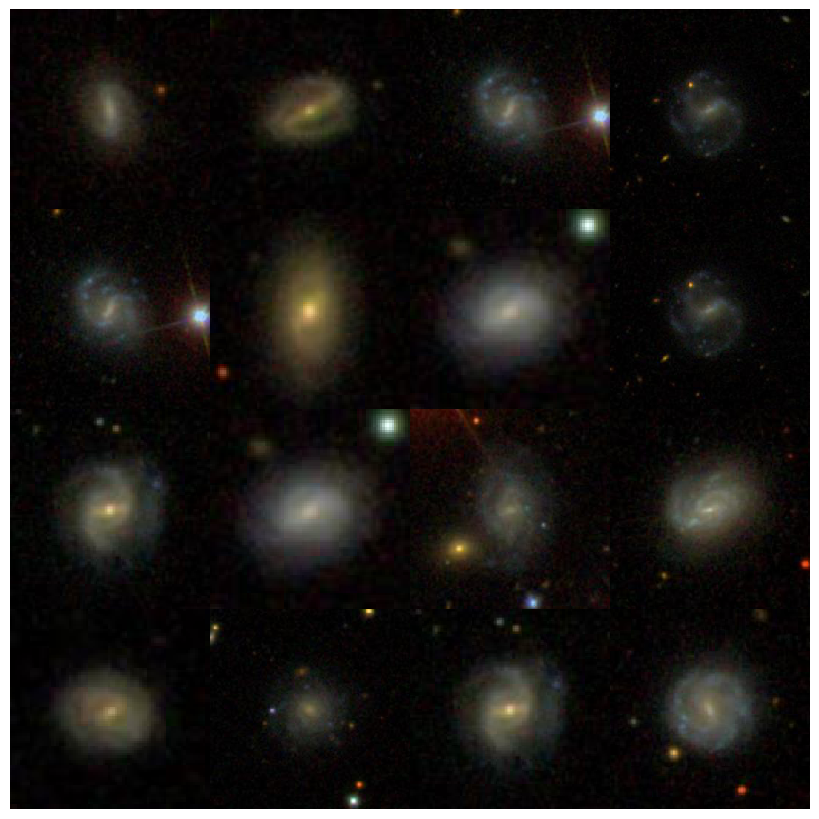

In [28]:
from PIL import Image
f, ax_ = plt.subplots(ncols=4, nrows=4, figsize=(8, 8), dpi=100)
ax = ax_.ravel()
for i, (idx, row) in enumerate(image_locs.iterrows()):
    ax[i].imshow(ims.loc[idx])#.resize((200, 200), Image.HAMMING))
    ax[i].axis('off')
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
plt.savefig(os.path.expanduser('~/PhD/Thesis/images/chapter1/barred-galaxies.png'), bbox_inches='tight')